In [1]:
import torch

## Tensors and Autograd

Torch at its core implements automatic differentiation on arbitrary
computation graphs of tensors. To give a simple example consider
addition of two tensors
$$
y = x_1 + x_2
$$
then we have
$$
dy = dx_1 + dx_2
$$
and therefore the gradient passed into $dy$ gets copied to the input
nodes $dx_1$ and $dx_2$. Indeed this is what happens if do
this simple operation in PyTorch:

In [21]:
x_1 = torch.randn(3, requires_grad=True)
x_2 = torch.randn(3, requires_grad=True)
y = x_1 + x_2

y.backward(torch.ones(3))
x_1.grad, x_2.grad

(tensor([1., 1., 1.]), tensor([1., 1., 1.]))

Similarly for multiplication
$$ 
y = x_1 \cdot x_2
$$
we have that
$$
dy = x_2 \cdot dx_1  + x_1 \cdot dx_2
$$
Which means that whatever gradient gets passed into $dy$
get's multiplied by the input $x_2$ for the node $dx_1$ and
by $x_1$ for the node $dx_2$:

In [20]:
x_1 = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
x_2 = torch.tensor([2.0, 3.0, 4.0], requires_grad=True)
y = x_1 * x_2
y.backward(torch.ones(3))
x_1.grad, x_2.grad

(tensor([2., 3., 4.]), tensor([1., 2., 3.]))

### Exercise:
Change the input tensor passed into $y$ in the backward calculation. Can you predict what will happen?

## Extending the Autograd Mechanism

If you compose primitives provided by PyTorch it will be able to the gradient computation
initiated by the "backward" call for you. This is why it is called "Autograd". However in
some situations it is advantageous to implement your own autograd primitives.

To give you a first example, assume that the multiplication primitive was not build into PyTorch here is how you could implement it yourself:

In [26]:
class Mult(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_1, x_2):
        ctx.save_for_backward(x_1, x_2)
        return x_1 * x_2

    @staticmethod
    def backward(ctx, dy):
        x_1, x_2 = ctx.saved_tensors
        return (x_2 * dy, x_1 * dy)

mult = Mult.apply

Indeed we get the same result as above:

In [27]:
x_1 = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
x_2 = torch.tensor([2.0, 3.0, 4.0], requires_grad=True)
y = mult(x_1, x_2)
y.backward(torch.ones(3))
x_1.grad, x_2.grad

(tensor([2., 3., 4.]), tensor([1., 2., 3.]))

### Exercise
Implement your own addition primitive and check that it matches with the default addition primitive provided by PyTorch.

## Sequential Composition

A lot of neural networks can be described as the sequential composition of layers, the autograd mechanism then ensures that errors are propagated in reverse order through all layers. Consider
for example a function that multiplies its input by $2$.

In [28]:
def mult_by_2(x):
    return 2 * x

Then we can express a function that multiplies its input by 8 as follows:

In [29]:
def mult_by_8(x):
    x = mult_by_2(x)
    x = mult_by_2(x)
    x = mult_by_2(x)
    return x

In [30]:
x_1 = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
y = mult_by_8(x_1)
y.backward(torch.ones(3))
x_1.grad

tensor([8., 8., 8.])

Now imagine that for some reason we were unsure what the best value to multiply by in each layer  would be, so we instead introduce parameters $p_1, p_2, p_3$ by which we want to multiply.

In [104]:
def mult_by_p(x, p):
    x = mult(x, p[0]) # we are using our "own" multiplication function here
    x = mult(x, p[1])
    x = mult(x, p[2])
    return x

The final step is then to find "good" parameters given a certain task. If the task
is for example for the function to multiply by 8 overall, which it surely can
solve using the parameters $p_1 = 2, p_2 = 2, p_3 = 2$, we can instead create training
data and target data and use an optimisation algorithm to find a solution to
this problem aswell.

In [118]:
# we initially choose randomly chosen parameters 
p = [torch.randn(3, requires_grad=True), torch.randn(3, requires_grad=True), torch.randn(3, requires_grad=True)]

# Number of training samples 
K = 1000

# this would correspond to the input dataset in a real world example
# we generate K random triples of three numbers
xs = torch.randn(K, 3, requires_grad=False)

# our target is for the data to be multiplied by 8 
ys = 8 * xs

# the loss measures how well we are currently doing, here
# we choose to compare using the l1-norm
loss = torch.nn.L1Loss()

# the last ingredient is the optimisation algorithm to use
# SGD performs the update step
#
# p[i] = p[i] + lr * p[i].grad
#
opt = torch.optim.SGD(p, lr=0.01)

# Number of steps we want to optimize for
N = 1000

losses = []

# optimization loop
for i in range(N):
    # set all gradients p[i].grad to zero
    opt.zero_grad()
    # compute the distance from the desired outcome
    l = loss(mult_by_p(xs, p), ys)
    # propagate the gradient
    l.backward()
    # take a gradient descent step 
    opt.step()
    # save the loss for later plotting
    losses.append(l.data)

print(f"Final loss: {l}")

Final loss: 0.030491871759295464


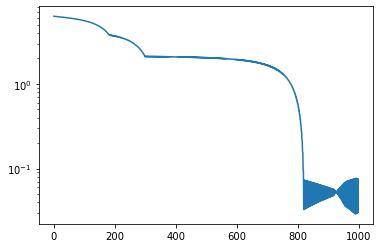

In [119]:
import matplotlib.pyplot as plt
plt.semilogy(losses)

We can evaluate the function with our trained parameters and
find that provided the loss reached a sufficiently small value
(< 0.1 say), that the function indeed approximately multiplies
by 8:

In [122]:
mult_by_p(torch.ones(3), p)

tensor([8.0977, 7.9388, 8.1264], grad_fn=<MultBackward>)

There is of course not one unique way of multiplying by $8$ 
given three parameters and indeed gradient descent finds 
different ways of doing so. 

In [123]:
p

[tensor([1.9752, 2.4792, 1.7747], requires_grad=True),
 tensor([-1.9836, -2.0287, -2.5289], requires_grad=True),
 tensor([-2.0668, -1.5784, -1.8107], requires_grad=True)]